In [1]:
import uproot as ur
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

import pandas as pd
from pyjet import cluster
from pyjet.testdata import get_event
from pyjet import DTYPE_EP
from pyjet import DTYPE_PTEPM
from pyjet import PseudoJet, JetDefinition, ClusterSequence, ClusterSequenceArea


## Get data, transform ROOT tree into array

In [2]:
#events = ur.open('root://sci-xrootd.jlab.org//osgpool/eic/ATHENA/RECO/JETS/crossDivNrgCrab/DIS_NC_Q2gt10_crossDivNrgCrab_25mRad_18x275_v1.0001.root:events')

#gen_events = ur.open('root://sci-xrootd.jlab.org//osgpool/eic/ATHENA/FULL/JETS/crossDivNrgCrab/DIS_NC_Q2gt10_crossDivNrgCrab_25mRad_18x275_v1.0001.root:events')
events = ur.open('rec_highq2.root:events')
gen_events = ur.open('sim_highq2.root:events')

In [3]:
def get_vector(varname='HcalHadronEndcapClusters',energy='energy'):
    E = events["%s.%s"%(varname,energy)].array(library='np')
    x = events["%s.position.x"%varname].array(library='np')
    y = events["%s.position.y"%varname].array(library='np')
    z = events["%s.position.z"%varname].array(library='np')
    theta = events["%s.polar.theta"%varname].array(library='np')
    phi = events["%s.polar.phi"%varname].array(library='np')

    return E,x, y, z, theta, phi

In [4]:
def get_truth():
    pdgID = gen_events['mcparticles.pdgID'].array(library='np')
    status = gen_events['mcparticles.status'].array(library='np')
    genStatus = gen_events['mcparticles.genStatus'].array(library='np')
    pex = gen_events['mcparticles.psx'].array(library='np')
    pey = gen_events['mcparticles.psy'].array(library='np')
    pez = gen_events['mcparticles.psz'].array(library='np')
    mass = gen_events['mcparticles.mass'].array(library='np')
    return pdgID,status, genStatus,pex,pey,pez, mass

In [5]:
E = {}
x = {}
y = {}
z  = {}
theta={}
phi = {}

## Get clusters

In [6]:
for i in ['HcalHadronEndcapClusters','HcalBarrelClusters','EcalEndcapPClusters','EcalEndcapNClusters','EcalBarrelClusters']:
    E[i], x[i], y[i],z[i], theta[i], phi[i]= get_vector("%s"%i,energy='energy')

## Get truth info

In [7]:
mc = {} 
mc['pdgID'], mc['status'], mc['genStatus'], mc['pex'],mc['pey'], mc['pez'], mc['mass']= get_truth()

## Initialize fast jet 

In [8]:
vectors = get_event()
sequence = cluster(vectors, R=1.0, p=-1)
jets = sequence.inclusive_jets()  # list of PseudoJets

In [9]:
def isolation(cone_theta,cone_phi, cluster_container, E_threshold=0.1):
    nclusters= len(cluster_container['E'])
    cone_eta = -np.log(np.tan(cone_theta/2.0))
    cone_iso = 0.0
    for i in range(nclusters):
        clus_E = cluster_container['E'][i]/1000.0
        if(clus_E<E_threshold):
            continue
        clus_E = cluster_container['E'][i]/1000.0
        clus_phi = cluster_container['phi'][i]
        clus_theta = cluster_container['theta'][i]
        clus_eta = -np.log(np.tan(clus_theta/2.0))
        clus_pt  = clus_E*np.sin(clus_theta)
        dphi = clus_phi - cone_phi
        dphi = (dphi + np.pi) % (2 * np.pi) - np.pi
        dr = np.sqrt((dphi)**2 + (clus_eta-cone_eta)**2)
        if(dr<1.0): 
            cone_iso += clus_E
    
    return cone_iso

def find_truth_electron(mc_container):
    ptmax = 0.0
    index_e = -999
    for i in range(len(mc_container['pdgID'])):
        if (mc_container['pdgID'][i]!=11): continue
        px = mc_container['pex'][i]
        py = mc_container['pey'][i]
        pt = np.sqrt(px*px+py*py)
        if(pt>ptmax):
            ptmax = pt
            index_e=i
    return index_e
            
def find_electron(cluster_container,hcal_container, E_threshold=3.0):
    ptmax = 0.0
    electron_iso = 999
    index_max = -999
    nclusters= len(cluster_container['E'])

    for i in range(nclusters):
        clus_E = cluster_container['E'][i]/1000.0
        if(clus_E<E_threshold):
            continue
        if(cluster_container['theta'][i]*180.0/np.pi<2):
            continue
        clus_theta = cluster_container['theta'][i]
        clus_phi = cluster_container['phi'][i]
        clus_eta = -np.log(np.tan(clus_theta/2.0))
        clus_pt  = clus_E*np.sin(clus_theta)
        clus_ecal_iso = isolation(clus_theta,clus_phi, cluster_container)
        clus_hcal_iso = isolation(clus_theta,clus_phi, hcal_container)
        clus_iso = clus_ecal_iso + clus_hcal_iso - clus_E
        if(clus_iso>clus_E*0.1): continue
        
        if(clus_pt>ptmax):
            ptmax = clus_pt
            index_max = i
            electron_iso= clus_iso 

    return index_max
    
def get_Empz(cluster_container,skip=None):
    nclusters= len(cluster_container['E'])
    Empz = 0.0
    for i in range(nclusters):
        if( skip is not None):
            if(skip==i):
                continue
        Empz += cluster_container['E'][i]*(1-np.cos(cluster_container['theta'][i]))
    return Empz/1000.0

def get_total_pxpy(cluster_container,E_threshold=0.1,skip=None):
    nclusters= len(cluster_container['E'])
    sum_px = 0.0
    sum_py = 0.0
    sum_pt = 0.0
    for i in range(nclusters):
        
        if( skip is not None):
            if(skip==i):
                continue
        
        clus_E = cluster_container['E'][i]/1000.0
        if(clus_E<E_threshold):
            continue
        clus_phi =   cluster_container['phi'][i]
        clus_theta = cluster_container['theta'][i]
        clus_eta = -np.log(np.tan(clus_theta/2.0))
        clus_pt  = clus_E*np.sin(clus_theta)
        clus_px  = clus_pt*np.cos(clus_phi)
        clus_py  = clus_pt*np.sin(clus_phi)
        sum_px += clus_px
        sum_py += clus_py
    sum_pt = np.sqrt(sum_px*sum_px + sum_py*sum_py)
    return sum_px, sum_py


def get_kinematics_electron(e_index, cluster_container,beam_energy = 18.0):
    electron_E = cluster_container['E'][e_index]/1000.0
    electron_theta = cluster_container['theta'][e_index]
    electron_pt  = electron_E*np.sin(electron_theta)
    y  = 1 - (electron_E/(2.0*beam_energy))*(1-np.cos(electron_theta))
    Q2 = electron_pt**2/(1-y)
    return Q2, y

def get_kinematics_electron_truth(px,py,pz,beam_energy=18.0):
    electron_E = np.sqrt(px*px+py*py+pz*pz)
    electron_pt = np.sqrt(px*px+py*py)
    electron_theta = np.arccos(pz/electron_E)
    y  = 1 - (electron_E/(2.0*beam_energy))*(1-np.cos(electron_theta))
    Q2 = electron_pt**2/(1-y)
    return Q2, y, electron_E, electron_theta

## Loop over events, fill clusters into constituent arrays; run jet clustering 

In [10]:

evt_Q2 = np.array([])
evt_y = np.array([])
evt_Total = np.array([])
evt_Empz = np.array([])
evt_yh  = np.array([])
evt_Q2h = np.array([])
evt_ysigma  = np.array([])
evt_Q2sigma = np.array([])
gen_evt_Q2 = np.array([])
gen_evt_y = np.array([])

evt_e_eta = np.array([])
evt_e_E = np.array([])
evt_e_phi = np.array([])


jet_dphi = np.array([])
jet_ptratio = np.array([])
jet_eta = np.array([])
jet_E = np.array([])
jet_phi = np.array([])
jet_dr = np.array([])
evt_genjet_dphi = np.array([])
evt_genjet_ptratio = np.array([])
evt_genjet_eta = np.array([])
evt_genjet_E = np.array([])
evt_genjet_phi = np.array([])



nentries = len(E['HcalBarrelClusters'])
print('N entries ', nentries)
jet_def = JetDefinition(algo = 'genkt', R = 1.0,p=-1.0)

for ievt in range(nentries):
#for ievt in range(1000):
    #print('ievent' , ievt)
    #print('electron theta', electron_theta)
    evt_mc = {}
    evt_mc['pdgID'] = mc['pdgID'][ievt]
    evt_mc['genStatus'] = mc['genStatus'][ievt]
    evt_mc['pex'] = mc['pex'][ievt]
    evt_mc['pey'] = mc['pey'][ievt]
    evt_mc['pez'] = mc['pez'][ievt]
    evt_mc = pd.DataFrame.from_dict(evt_mc)
    evt_mc.eval('E= sqrt(pex*pex + pey*pey + pez*pez) ',inplace=True)
    #evt_mc.eval('theta= atan2(pey/pez) ',inplace=True)
    evt_mc.eval('pt = sqrt(pex*pex + pey*pey)',inplace=True)
    evt_mc.head()
    #Find true electron
    e_truth_index = find_truth_electron(evt_mc)
    
    gen_constituents = np.array([], dtype=DTYPE_PTEPM)
    ##gen-level particles
    for imc in range(len(mc['pdgID'][ievt])):
        if(mc['genStatus'][ievt][imc]!=1): continue
        if(mc['pdgID'][ievt][imc]==11): continue

        mc_px = mc['pex'][ievt][imc]
        mc_py = mc['pey'][ievt][imc]
        mc_pz = mc['pez'][ievt][imc]
        mc_mass = mc['mass'][ievt][imc]
        #print('px =%2.2f, py=%2.2f, pz=%2.2f, mass=%2.2f'%(mc_px,mc_py,mc_pz,mc_mass))
        mc_E = np.sqrt(mc_px*mc_px + mc_py*mc_py + mc_pz*mc_pz + mc_mass*mc_mass)
        mc_p = np.sqrt(mc_px*mc_px + mc_py*mc_py + mc_pz*mc_pz)
        mc_pt = np.sqrt(mc_px*mc_px + mc_py*mc_py)
        mc_theta = np.arccos(mc_pz/mc_p)
        mc_phi = np.arccos(mc_px/mc_pt)
        mc_eta = -np.log(np.tan(mc_theta/2.0))
        #mc_part = np.array([mc_E,mc_px,mc_py,mc_pz], dtype=DTYPE_EP)
        if(imc==e_truth_index):
            continue
        if(abs(mc_eta)>4.0):
            continue
        mc_part = np.array([(mc_pt, mc_eta, mc_phi, mc_mass)], dtype=DTYPE_PTEPM)
        gen_constituents = np.append(gen_constituents, mc_part)
    #generated-level jets
    genjets = ClusterSequence(gen_constituents, jet_def).inclusive_jets() 
    
    
    
    
    constituents = np.array([], dtype=DTYPE_PTEPM)#DTYPE_EP)
    hcal_clusters = {}
    ecal_clusters = {}
    hcal_clusters['E'] = np.concatenate((E['HcalBarrelClusters'][ievt], E['HcalHadronEndcapClusters'][ievt]), axis=0)
    hcal_clusters['phi']= np.concatenate((phi['HcalBarrelClusters'][ievt], phi['HcalHadronEndcapClusters'][ievt]), axis=0)
    hcal_clusters['theta'] = np.concatenate((theta['HcalBarrelClusters'][ievt], theta['HcalHadronEndcapClusters'][ievt]), axis=0)
    ecal_clusters['E'] = np.concatenate((E['EcalEndcapNClusters'][ievt],E['EcalBarrelClusters'][ievt], E['EcalEndcapPClusters'][ievt]), axis=0)
    ecal_clusters['phi'] = np.concatenate((phi['EcalEndcapNClusters'][ievt],phi['EcalBarrelClusters'][ievt], phi['EcalEndcapPClusters'][ievt]), axis=0)
    ecal_clusters['theta'] = np.concatenate((theta['EcalEndcapNClusters'][ievt],theta['EcalBarrelClusters'][ievt], theta['EcalEndcapPClusters'][ievt]), axis=0)
   
    e_index = find_electron(ecal_clusters,hcal_clusters)
    #print(e_index)
    if(e_index<0): 
        #print('Electron candidate with minimum 5 GeV energy was not found')
        continue
        
    electron_E = ecal_clusters['E'][e_index]/1000.0
    electron_theta = ecal_clusters['theta'][e_index]
    electron_phi  = ecal_clusters['phi'][e_index]
    
    
    constituents = np.array([], dtype=DTYPE_PTEPM)#DTYPE_EP)
    #looping over HCAl clusters
    for i in range(len(hcal_clusters['E'])):
        part_energy = hcal_clusters['E'][i]/1000.0
        if(part_energy<0.5):
            continue
        part_phi = hcal_clusters['phi'][i]
        part_theta = hcal_clusters['theta'][i]
        part_eta = -np.log(np.tan(part_theta/2.0))
        part_pt  = part_energy*np.sin(part_theta)
        #print('Energy=%2.2f GeV, phi =%2.2f rad, theta= %2.2f rad, eta=%2.2f, pT = %2.2f GeV'%(part_energy,part_phi,part_theta, part_eta,part_pt))
        cluster = np.array([(part_pt, part_eta, part_phi, 0.0)], dtype=DTYPE_PTEPM)
        constituents = np.append(constituents, cluster)
    #looping over ECal clusters
    for i in range(len(ecal_clusters['E'])):
        part_energy = ecal_clusters['E'][i]/1000.0
        if(part_energy<0.100):
            continue
        if (i==e_index):
            continue
        part_phi = ecal_clusters['phi'][i]
        part_theta = ecal_clusters['theta'][i]
        part_eta = -np.log(np.tan(part_theta/2.0))
        part_pt  = part_energy*np.sin(part_theta)
        #print('Energy=%2.2f GeV, phi =%2.2f rad, theta= %2.2f rad, eta=%2.2f, pT = %2.2f GeV'%(part_energy,part_phi,part_theta, part_eta,part_pt))
        cluster = np.array([(part_pt, part_eta, part_phi, 0.0)], dtype=DTYPE_PTEPM)
        constituents = np.append(constituents, cluster)
        
        

    #print(jets.pt)
    evt_e_eta = np.append(evt_e_eta, -np.log(np.tan(ecal_clusters['theta'][e_index]/2.0)))
    evt_e_E = np.append(evt_e_E,0.001*ecal_clusters['E'][e_index])
    evt_e_phi = np.append(evt_e_phi, ecal_clusters['phi'][e_index])
    
    ### Jet reconstruction    
    cs = ClusterSequence(constituents, jet_def) 
    jets = cs.inclusive_jets()
    
    #print('JETS')
    
    ##Loop over reconstructed jet container
    for jet in jets:
        if(jet.pt<5): continue
        #print(jet.pt*np.cosh(jet.eta))
        jet_E = np.append(jet_E,jet.pt*np.cosh(jet.eta))
        jet_eta = np.append(jet_eta,jet.eta)
        #print('jet pt =%2.2f, jet_phi= %2.2f, jet_eta=%2.2f'%(jet.pt,jet.phi,jet.eta))
        jet_phi = np.append(jet_phi, jet.phi)
        jet_dphi = np.append(jet_dphi,np.abs(ecal_clusters['phi'][e_index]-jet.phi) )
        jet_ptratio = np.append(jet_ptratio, jet.pt/(0.001*ecal_clusters['E'][e_index]*np.sin(ecal_clusters['theta'][e_index])))
    
        ##
        ##Loop over generated jet container, find a match
        dR_min =9
        matched = None
        for igen, genjet in enumerate(genjets):
            if(genjet.pt<5): continue
            #print('Candidate: number %d, genjet pt =%2.2f, genjet_phi= %2.2f, genjet_eta=%2.2f'%(igen, genjet.pt,genjet.phi,genjet.eta))
            dphi = jet.phi - genjet.phi
            dphi = (dphi + np.pi) % (2 * np.pi) - np.pi
            dr = np.sqrt((dphi)**2 + (jet.eta-genjet.eta)**2)
            #print('dr =%2.2f, dphi=%2.2f'%(dr, dphi))
            if(dr<dR_min):
                dR_min = dr
                matched = igen
        
        if (matched is not None):
            #print('Matched gen-level jet was found: igen ', matched)
            matchedjet = genjets[matched]
            #print('genjet pt =%2.2f, genjet_phi= %2.2f, genjet_eta=%2.2f'%(matchedjet.pt,matchedjet.phi,matchedjet.eta))
            jet_dr   = np.append(jet_dr, dR_min)
            evt_genjet_E = np.append(evt_genjet_E, matchedjet.pt*np.cosh(matchedjet.eta))
            evt_genjet_eta = np.append(evt_genjet_eta,matchedjet.eta)
            evt_genjet_phi = np.append(evt_genjet_phi,  matchedjet.phi)
        else:
            jet_dr   = np.append(jet_dr, dR_min)
            evt_genjet_E = np.append(evt_genjet_E,-999)
            evt_genjet_eta = np.append(evt_genjet_eta, -999)
            evt_genjet_phi = np.append(evt_genjet_phi, -999)
        #print('################################################')

    ##TRUTH
    

    
  
#print(jet_dr)
print('Number of jets', len(jet_E))
#print(evt_genjet_E)#

#print(jet_eta)
#print(evt_genjet_eta)

N entries  10000
Number of jets 5692


## Plotting 

In [11]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties

from numpy import inf

import os

rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

import matplotlib.pyplot as plt
import mplhep as hep
#hep.set_style(hep.style.CMS)
hep.set_style("CMS")

## Plot jet energy spectrum

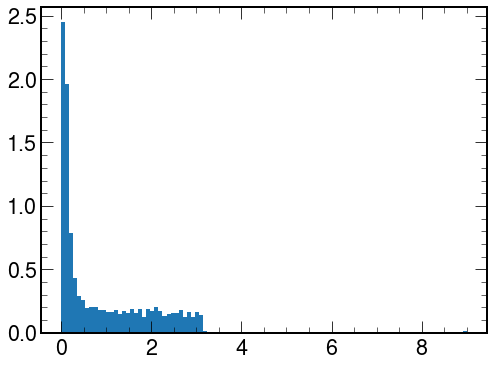

5692
5692


In [12]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.hist(jet_dr,density=True,bins=100)
plt.show()
print(len(jet_E))
print(len(evt_genjet_E))

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


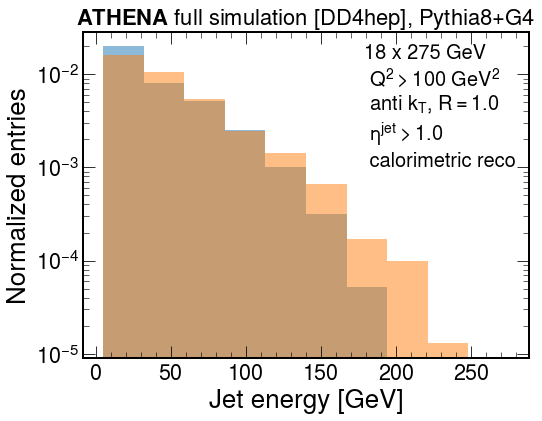

In [13]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.hist(jet_E,density=True,alpha=0.5,range=(5,275))
ax.hist(evt_genjet_E,density=True,alpha=0.5,range=(5,275))

plt.text(0.80, 0.77,'18 x 275 GeV \n $Q^{2}>100~GeV^{2}$ \n anti $k_{T}$, $R=1.0$ \n $\eta^{jet}>1.0$ \n calorimetric reco',
                 horizontalalignment='center',multialignment='left',
                 verticalalignment='center',transform = ax.transAxes, fontsize=20)
plt.title(r"$\bf{ATHENA}$"+' full simulation [DD4hep], Pythia8+G4',fontsize=22)
plt.ylabel('Normalized entries')
plt.xlabel('Jet energy [GeV]')
plt.yscale('log')
plt.show()
##

## Plot pseudorapidity

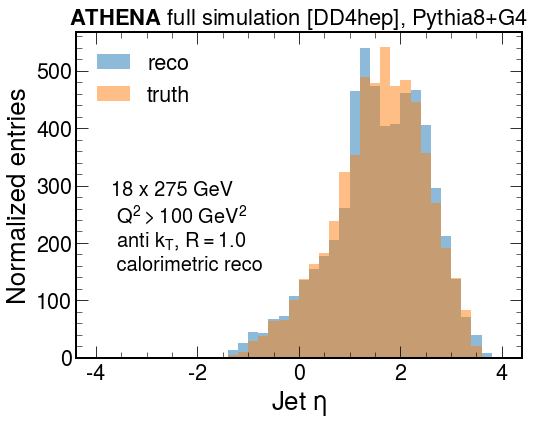

In [14]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.hist(jet_eta,alpha=0.5,range=(-4,4),bins=40,label='reco')

ax.hist(evt_genjet_eta,alpha=0.5, range=(-4,4),bins=40,label='truth')

plt.text(0.25, 0.4,'18 x 275 GeV \n $Q^{2}>100~GeV^{2}$ \n anti $k_{T}$, $R=1.0$\n calorimetric reco',
                 horizontalalignment='center',multialignment='left',
                 verticalalignment='center',transform = ax.transAxes, fontsize=20)
plt.title(r"$\bf{ATHENA}$"+' full simulation [DD4hep], Pythia8+G4',fontsize=22)
plt.ylabel('Normalized entries')
plt.xlabel('Jet $\eta$')

plt.legend(loc='best')
plt.show()

In [15]:
df = {}
df['jet_E'] = jet_E
df['jet_eta'] = jet_eta
df['jet_phi'] = jet_phi

df['genjet_E'] = evt_genjet_E
df['genjet_eta'] = evt_genjet_eta
df['genjet_phi'] = evt_genjet_phi

df['jet_dr']  = jet_dr


df = pd.DataFrame.from_dict(df)

df.eval('res_E = (jet_E-genjet_E)/genjet_E',inplace=True)

df.query('jet_dr<0.9').head()

,jet_E,jet_eta,jet_phi,genjet_E,genjet_eta,genjet_phi,jet_dr,res_E
0,118.118819,3.670146,2.429344,171.060534,3.420802,2.116060,0.400398,-0.309491
1,75.749219,2.379808,0.785882,67.436716,2.426288,0.766161,0.050490,0.123264
2,15.938165,1.517557,0.207634,27.806211,1.674011,0.310907,0.187466,-0.426813
6,11.386932,1.035420,-0.303543,19.285603,1.039798,0.308029,0.611587,-0.409563
7,5.908279,-0.011484,2.559785,10.055409,-0.072103,2.714231,0.165915,-0.412428


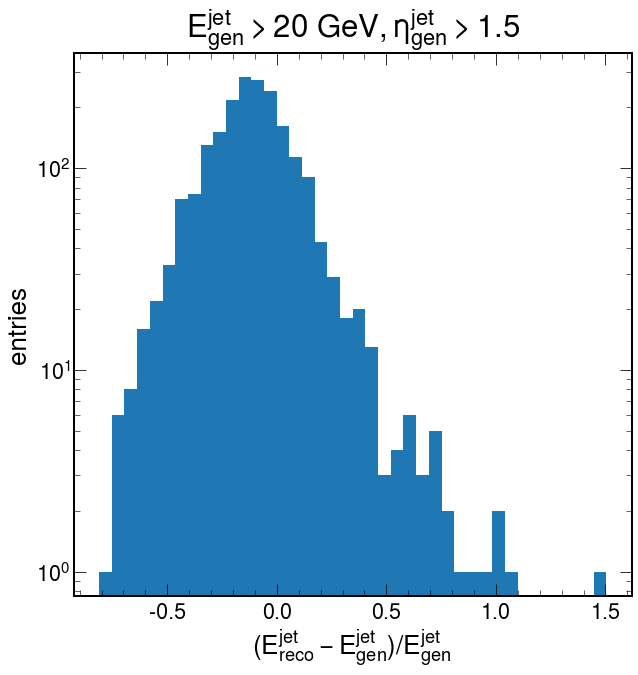

In [28]:
plt.hist(df.query('jet_dr<0.9 and genjet_E>20 and genjet_eta>1.5')['res_E'],bins=40)
plt.yscale('log')
plt.ylabel('entries')
plt.xlabel('$(E^{jet}_{reco} - E^{jet}_{gen} ) / E^{jet}_{gen}$ ')
plt.title('$E^{jet}_{gen}>20 \mathrm{~GeV}, \eta^{jet}_{gen}>1.5$')
plt.show()

[24.175, 34.2685, 48.576499999999996, 68.858, 97.6075, 138.3605, 196.128]


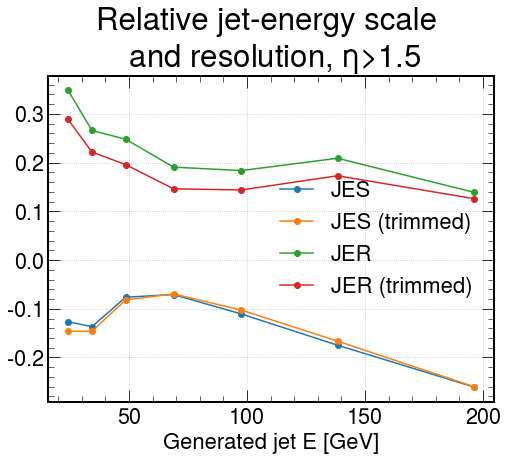

<Figure size 720x720 with 0 Axes>

In [36]:
from scipy import stats

fig = plt.figure( figsize=(8, 6))
temp = df.query('genjet_eta>1.5').groupby(pd.cut(df.query('genjet_eta>1.5')['genjet_E'], bins=np.geomspace(20,230,8)))['res_E']
trim_mean = temp.apply(stats.trim_mean, 0.025)
trim_std = temp.apply(stats.mstats.trimmed_std, limits=(0.025,0.025))
temp = temp.agg(['mean', 'std', 'size']).reset_index()


x = [i.mid for i in temp['genjet_E']]
print (x)
plt.plot(x,temp['mean'],'o-',label='JES')
plt.plot(x,trim_mean,'o-',label='JES (trimmed)')

plt.plot(x,temp['std'],'o-',label='JER')
plt.plot(x, trim_std,'o-',label='JER (trimmed)')
plt.xlabel('Generated jet E [GeV]',fontsize=22)
plt.legend(fontsize=22)
plt.title('Relative jet-energy scale \n and resolution, $\eta$>1.5')
plt.grid()
#plt.ylim([-0.4,0.5])
plt.show()
plt.tight_layout()
#fig.savefig('figures/Jetperformance_jetpt.pdf')
#fig.savefig('figures/Jetperformance_jetpt.png')

[-3.7145, -3.143, -2.5715000000000003, -2.0, -1.4285, -0.857, -0.2855, 0.2855, 0.857, 1.4285, 2.0, 2.5715000000000003, 3.143, 3.7145]


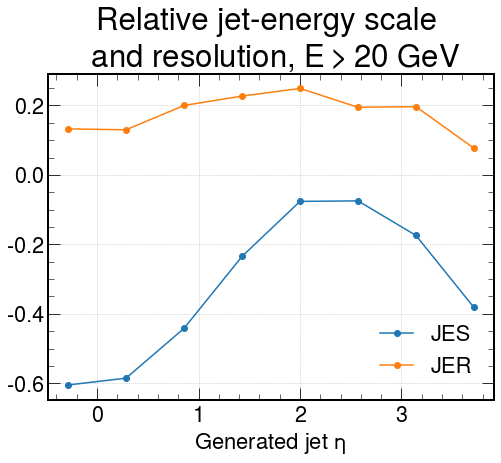

<Figure size 720x720 with 0 Axes>

In [18]:
fig = plt.figure( figsize=(8, 6))
temp = df.query('genjet_E>20').groupby(pd.cut(df.query('genjet_E>20')['genjet_eta'], bins=np.linspace(-4,4,15)))['res_E']
temp = temp.agg(['mean', 'std', 'size'])
temp = temp.reset_index()

x = [i.mid for i in temp['genjet_eta']]
print (x)
plt.plot(x,temp['mean'],'o-',label='JES')
plt.plot(x,temp['std'],'o-',label='JER')
plt.xlabel('Generated jet $\eta$ ',fontsize=22)
plt.legend(fontsize=22)
plt.title('Relative jet-energy scale \n and resolution, $E>20$ GeV')
plt.grid()
#plt.ylim([-0.4,0.5])
plt.show()
plt.tight_layout()

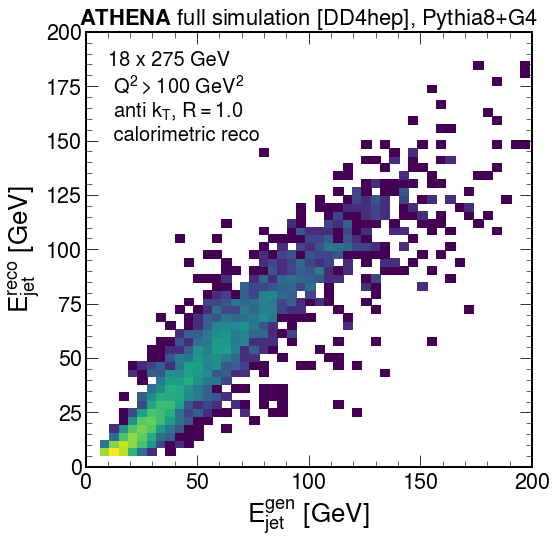

In [52]:
fig = plt.figure( figsize=(8, 8))

plt.hist2d(df.query('jet_dr<0.9')['genjet_E'], df.query('jet_dr<0.9')['jet_E'], bins=(50, 50),  norm=mpl.colors.LogNorm(),cmap=plt.cm.viridis)
plt.ylim([0,200])
plt.xlim([0,200])
plt.xlabel('$E^{gen}_{jet}$ [GeV]')
plt.ylabel('$E^{reco}_{jet}$ [GeV]')
plt.title(r"$\bf{ATHENA}$"+' full simulation [DD4hep], Pythia8+G4',fontsize=22)
plt.text(0.25, 1.2,'18 x 275 GeV \n $Q^{2}>100~GeV^{2}$ \n anti $k_{T}$, $R=1.0$\n calorimetric reco',
                 horizontalalignment='center',multialignment='left',
                 verticalalignment='center',transform = ax.transAxes, fontsize=20)

plt.show()